In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt

# Loading The Data

In [5]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',batch_size = 64,augment = False,random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Example to test the shape of images in trainloader
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Image batch shape: {images.shape}")

Image batch shape: torch.Size([64, 3, 227, 227])


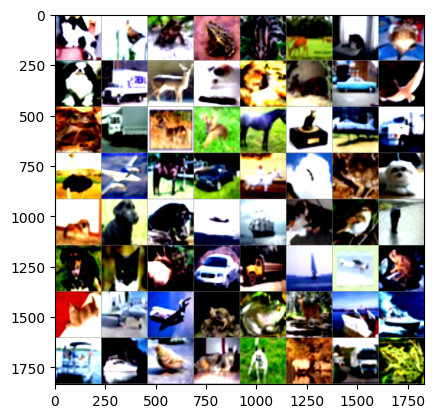

dog   bird  frog  frog  frog  deer  cat   cat   dog   truck deer  cat   dog   deer  car   bird  frog  truck deer  deer  horse cat   plane truck bird  plane horse car   horse bird  frog  dog   dog   dog   horse plane ship  dog   bird  cat   dog   cat   deer  car   truck ship  plane frog  cat   plane plane frog  frog  deer  ship  ship  ship  ship  bird  cat   cat   deer  truck frog 


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # define classes

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose to (H, W, C)
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images (will show 227x227 images now)
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

# AlexNet Architecture

In [9]:
class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,96,11,4)
    self.conv2 = nn.Conv2d(96,256,5,1,2)
    self.conv3 = nn.Conv2d(256,384,3,1,1)
    self.conv4 = nn.Conv2d(384,384,3,1,1)
    self.conv5 = nn.Conv2d(384,256,3,1,1)

    self.fc1 = nn.Linear(6*6*256,4096)
    self.fc2 = nn.Linear(4096,4096)
    self.fc3 = nn.Linear(4096,10)

    self.dropout = nn.Dropout(p=0.5)
  def forward(self , x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,3,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,3,2)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x,3,2)
    x = self.dropout(x)

    x = x.view(-1, 6*6*256)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet().to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(train_loader)

In [12]:

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))


Epoch [1/20], Step [704/704], Loss: 1.2572
Accuracy of the network on the 5000 validation images: 39.58 %
Epoch [2/20], Step [704/704], Loss: 1.1308
Accuracy of the network on the 5000 validation images: 50.54 %
Epoch [3/20], Step [704/704], Loss: 1.6012
Accuracy of the network on the 5000 validation images: 56.2 %
Epoch [4/20], Step [704/704], Loss: 0.7087
Accuracy of the network on the 5000 validation images: 63.12 %
Epoch [5/20], Step [704/704], Loss: 0.9269
Accuracy of the network on the 5000 validation images: 68.1 %
Epoch [6/20], Step [704/704], Loss: 1.7698
Accuracy of the network on the 5000 validation images: 71.34 %
Epoch [7/20], Step [704/704], Loss: 0.9059
Accuracy of the network on the 5000 validation images: 72.86 %
Epoch [8/20], Step [704/704], Loss: 0.5290
Accuracy of the network on the 5000 validation images: 74.76 %
Epoch [9/20], Step [704/704], Loss: 0.5175
Accuracy of the network on the 5000 validation images: 76.94 %
Epoch [10/20], Step [704/704], Loss: 0.2077
Accu

In [15]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH) # Changed net to model

In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 77.38 %
